# DATA C88C (Fall 2025) Ants Project EDA

## Setup

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import sqlite3
import json

In [2]:
# Connect to the database
DB_PATH = "../../data/private/data_c88c_fa25.db"
conn = sqlite3.connect(DB_PATH)
cursor = conn.cursor()

## How many students are there with Ants backups?

In [3]:
# TODO: exclude from this analysis edwinator321@gmail.com?

In [4]:
cursor.execute("SELECT COUNT(DISTINCT student_email) FROM backup_metadata")
num_students = cursor.fetchone()[0]
num_students

470

## How many backups are there total?

In [5]:
cursor.execute("SELECT COUNT(*) FROM backup_metadata")
num_backups_total = cursor.fetchone()[0]
num_backups_total

33323

## How many backups are there per student?

In [6]:
cursor.execute("SELECT COUNT(*) FROM backup_metadata GROUP BY student_email")
num_backups_per_student = np.array([row[0] for row in cursor.fetchall()])

In [7]:
np.min(num_backups_per_student)

np.int64(1)

In [8]:
np.mean(num_backups_per_student)

np.float64(70.9)

In [9]:
np.median(num_backups_per_student)

np.float64(65.0)

In [10]:
# NOTE: When retrieving backups, we set a limit of 150 backups,
# so there is likely a ceiling effect here
np.max(num_backups_per_student)

np.int64(150)

<Axes: ylabel='Count'>

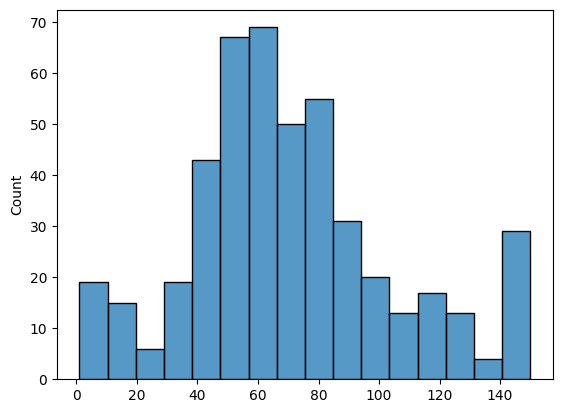

In [11]:
sns.histplot(num_backups_per_student)

## When did students start/finish the assignment? (first backup timestamp vs. last backup timestamp)

In [12]:
cursor.execute("""
    SELECT MIN(created) AS first_created
    FROM backup_metadata
    GROUP BY student_email
""")
first_backup_dates = np.array([row[0] for row in cursor.fetchall()]).astype('datetime64[s]')

In [13]:
cursor.execute("""
    SELECT MAX(created) AS first_created
    FROM backup_metadata
    GROUP BY student_email
""")
last_backup_dates = np.array([row[0] for row in cursor.fetchall()]).astype('datetime64[s]')

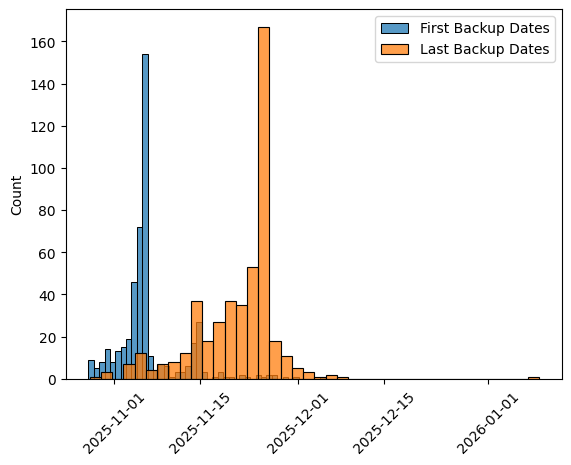

In [14]:
sns.histplot(first_backup_dates, label='First Backup Dates')
sns.histplot(last_backup_dates, label='Last Backup Dates')
plt.xticks(rotation=45)
plt.legend()

In FA25, Ants was released 10/27 and due 11/25. To make the histogram easier to interpret, we exclude students who ended after 12/1.

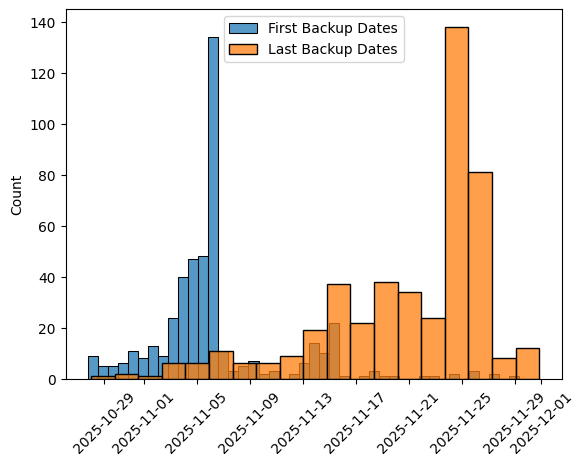

In [30]:
mask = last_backup_dates <= np.datetime64('2025-12-01')
sns.histplot(first_backup_dates[mask], label='First Backup Dates')
sns.histplot(last_backup_dates[mask], label='Last Backup Dates')
plt.xticks(rotation=45)
plt.legend()

## What is the total time spent on the assignment (last backup timestamp - first backup timestamp)

In [16]:
cursor.execute("""
    SELECT
        student_email,
        MIN(created) AS first_created,
        MAX(created) AS last_created,
        (julianday(MAX(created)) - julianday(MIN(created))) * 24 * 60 * 60 as diff_seconds
    FROM backup_metadata
    GROUP BY student_email
""")
total_duration_sec = np.array([row[3] for row in cursor.fetchall()])

Note: We convert back to total duration in days for better interpretability here

In [17]:
total_duration_days = total_duration_sec / (24 * 60 * 60)

In [18]:
np.min(total_duration_days)

np.float64(0.0)

In [19]:
np.mean(total_duration_days)

np.float64(14.744731579984519)

In [20]:
np.median(total_duration_days)

np.float64(17.11336805555038)

In [21]:
np.max(total_duration_days)

np.float64(58.196574073750526)

<Axes: ylabel='Count'>

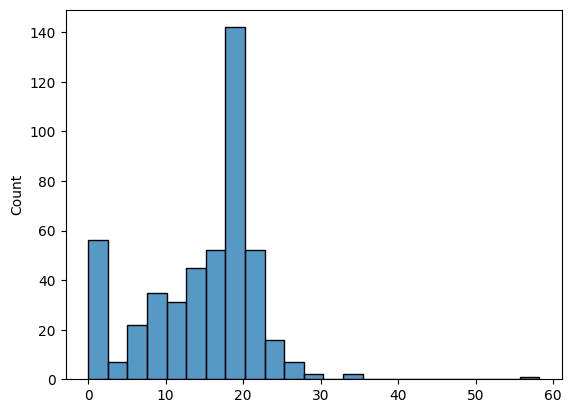

In [22]:
sns.histplot(total_duration_days)

Examine the histogram eliminating outliers. From eyeballing, most students took 40 days or less to do the assignment.

<Axes: ylabel='Count'>

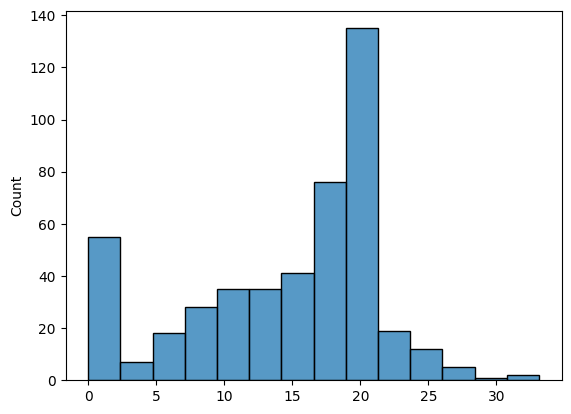

In [31]:
sns.histplot(total_duration_days[total_duration_days <= 40])

## How many problems did students solve by their last backup?

In [24]:
cursor.execute("""
WITH last_backups AS (
    SELECT
        student_email,
        backup_id,
        MAX(created) AS last_created
    FROM backup_metadata
    GROUP BY student_email
)

SELECT
    lb.*,
    history
FROM analytics_messages AS am
JOIN last_backups AS lb
ON am.backup_id = lb.backup_id
""")
last_backup_analytics_histories = [json.loads(row[3]) for row in cursor.fetchall()]
last_backup_analytics_histories[0]

[{'display_name': 'Problem 0', 'attempts': 1, 'solved': True},
 {'display_name': 'Problem 1', 'attempts': 2, 'solved': True},
 {'display_name': 'Problem 2', 'attempts': 2, 'solved': True},
 {'display_name': 'Problem 3', 'attempts': 2, 'solved': True},
 {'display_name': 'Problem 4', 'attempts': 2, 'solved': True},
 {'display_name': 'Problem 5', 'attempts': 2, 'solved': True},
 {'display_name': 'Problem 6', 'attempts': 2, 'solved': True},
 {'display_name': 'Problem 7', 'attempts': 2, 'solved': True},
 {'display_name': 'Problem 8a', 'attempts': 2, 'solved': True},
 {'display_name': 'Problem 8b', 'attempts': 3, 'solved': True},
 {'display_name': 'Problem 8c', 'attempts': 2, 'solved': True},
 {'display_name': 'Problem 9', 'attempts': 3, 'solved': True},
 {'display_name': 'Problem 10', 'attempts': 2, 'solved': True},
 {'display_name': 'Problem 11', 'attempts': 2, 'solved': True},
 {'display_name': 'Problem 12', 'attempts': 2, 'solved': True}]

In [25]:
def count_problems_solved(history: list[dict]) -> int:
    solved = 0
    for problem in history:
        if problem['solved']:
            solved += 1
    return solved

In [26]:
last_backup_problems_solved = np.array(list(map(count_problems_solved, last_backup_analytics_histories)))
last_backup_problems_solved[0]

np.int64(15)

It looks like this semester students attempted to do the optional problems (standard set contains 15 problems. There are 4 optional problems.)

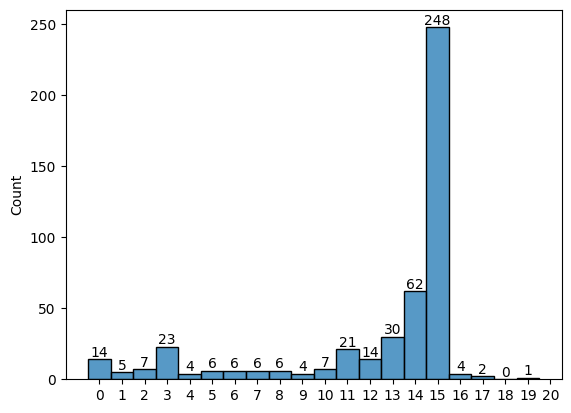

In [27]:
ax = sns.histplot(last_backup_problems_solved, discrete=True)
# Display counts at the top of each bar
ax.bar_label(ax.containers[0])
# Force xticks to be every 1 unit
ax.set_xticks(range(int(min(last_backup_problems_solved)), int(max(last_backup_problems_solved)) + 2))
plt.show()

## How many students did autograder spam, defined as >= 20 backups where each consecutive backup is < 5 min apart?

In [28]:
cursor.execute("""
WITH gaps AS (
    SELECT
        student_email,
        -- need this column so that we can create windows ordered by `created` column in CTE below
        created,
        -- Calculate the gap between current and previous
        (julianday(created) - LAG(julianday(created)) OVER (PARTITION BY student_email ORDER BY created)) * 24 * 60 AS gap_minutes
    FROM backup_metadata
),

groups_of_ten AS (
    SELECT
        student_email,
        MAX(gap_minutes) OVER w AS max_gap_in_window,
        -- window may be less than 10, e.g. if processing 1st row
        -- so we have to check the count later
        COUNT(*) OVER w AS num_backups
    FROM gaps
    WINDOW w AS (
        PARTITION BY student_email
        ORDER BY created
        ROWS BETWEEN 20 - 1 PRECEDING AND CURRENT ROW
    )
)

SELECT DISTINCT student_email
FROM groups_of_ten
WHERE max_gap_in_window <= 5 AND num_backups = 20
""")
len(cursor.fetchall())

132

## Teardown

In [29]:
# Close db connection
conn.close()

# TODO Questions

file contents:

- how many students used print debugging?
- how many students used print("DEBUG: ...")
- how many students used print debugging successfully? (file contents had `print` somewhere and following backup passed more or all tests?)


.json data:

- How many backups corresponded to each problem?
- How much time was spent working on each problem?


- Average # of lines added from first backup to last backup?
- How many lines change between backups (summary statistics)?


- Do students typically do unlocking tests before? How many attempts does it take vs. getting everything 100% on first try?

lint:

- What are the most common lint errors for final backup for each student?